In [1]:
## DEPENDENCIES 
!pip install ray
!pip install pyarrow
!pip install tabulate
!pip install opendatasets
!pip install opencv-python
!pip install torchmetrics

In [2]:
## IMPORT
import opendatasets as od
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import ray
from ray import train
from ray.air import session
from ray.air.config import ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
from ray.data.preprocessors import Concatenator, Chain, StandardScaler
from ray import tune
from ray.tune.tuner import Tuner, TuneConfig
from ray.air.config import RunConfig
from ray.train.batch_predictor import BatchPredictor
from ray.train.torch import TorchPredictor
from ray.data.preprocessor import Preprocessor
from ray.data.aggregate import Max
from ray.data.datasource.partitioning import Partitioning
from ray.data.preprocessors import Concatenator, Chain, StandardScaler
import cv2

from PIL import Image
import os
from torchmetrics import Accuracy


from ray import tune
from ray.tune.tuner import Tuner, TuneConfig
from ray.air.config import RunConfig
from ray.train.batch_predictor import BatchPredictor
from ray.train.torch import TorchPredictor

In [3]:
## DATASET DOWNLOAD
od.download(
    "https://www.kaggle.com/datasets/wwymak/architecture-dataset")

Skipping, found downloaded files in "./architecture-dataset" (use force=True to force download)


In [4]:
## DATASET LOADING

HEIGHT = 224
WIDTH = 224

root = "architecture-dataset/arcDataset/"
partitioning = Partitioning("dir", field_names=["class"], base_dir=root)
dataset = ray.data.read_images(root, partitioning=partitioning, size=(HEIGHT, WIDTH), mode="RGB")
train_dataset, validation_dataset = dataset.train_test_split(test_size=0.3)

2023-01-08 22:02:43,228	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
Read progress: 100%|██████████| 200/200 [00:00<00:00, 3055.40it/s]


In [5]:
## EXEMPLARY ELEMENT FROM THE DATASET

In [6]:
## PREPROCESSING

CLASS_ID_MAPPING = {'Achaemenid architecture': 0,
                    'American Foursquare architecture': 1, 
                    'American craftsman style': 2, 
                    'Ancient Egyptian architecture': 3, 
                    'Art Deco architecture': 4,
                    'Art Nouveau architecture': 5,
                    'Baroque architecture': 6,
                    'Bauhaus architecture': 7,
                    'Beaux-Arts architecture': 8,
                    'Byzantine architecture': 9,
                    'Chicago school architecture': 10,
                    'Colonial architecture': 11,
                    'Deconstructivism': 12,
                    'Edwardian architecture': 13,
                    'Georgian architecture': 14,
                    'Gothic architecture': 15,
                    'Greek Revival architecture': 16,
                    'International style': 17,
                    'Novelty architecture': 18,
                    'Palladian architecture': 19, 
                    'Postmodern architecture': 20,
                    'Queen Anne architecture': 21, 
                    'Romanesque architecture': 22, 
                    'Russian Revival architecture': 23, 
                    'Tudor Revival architecture': 24}

ID_CLASS_MAPPING = {value: key for key, value in CLASS_ID_MAPPING.items()}

NUMBER_OF_CLASSES = len(CLASS_ID_MAPPING)

class OpenCVPreprocessor(Preprocessor):
    def _fit(self, dataset):
        self.stats_ = None
    
    def _transform_numpy(self, df):
        images = df["image"]
        result = []
        for image in images:
            image = cv2.resize(image, (HEIGHT,WIDTH), interpolation=cv2.INTER_CUBIC)
            result.append(np.transpose(image, (2, 0, 1)))
        result = np.array(result)
        df["image"] = result
        
        classes = df["class"]
        result = []
        for class_name in classes:
            result.append(CLASS_ID_MAPPING[class_name])
        result = np.array(result)
        df["class"] = result
        return df
    


Map_Batches: 100%|██████████| 61/61 [00:00<00:00, 108.25it/s]


CLASS: International style


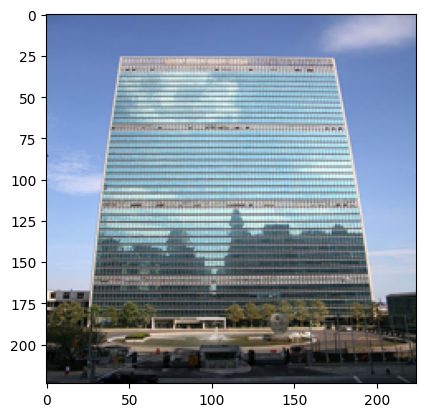

In [7]:
## EXEMPLARY ELEMENT FROM THE DATASET AFTER THE PREPROCESSING
transformed_validation_dataset = OpenCVPreprocessor().fit_transform(validation_dataset)
element = next(transformed_validation_dataset.iter_torch_batches(batch_size=1))

import matplotlib.pyplot as plt
print(f"CLASS: {ID_CLASS_MAPPING[element['class'].item()]}")
image = np.transpose(element["image"][0], (1, 2, 0))
plt.imshow(image)

In [8]:
## ResNet34 definition

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [9]:
# TRAINING
VALIDATION_DATASET_COUNT = validation_dataset.count()
def train_loop_per_worker(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["num_epochs"]
    number_of_classes = config["number_of_classes"]

    train_data = session.get_dataset_shard("train")
    validation_data = session.get_dataset_shard("validation")
    model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=number_of_classes)
    model = train.torch.prepare_model(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay = 0.001, momentum = 0.9)
    
    for cur_epoch in range(epochs):
        batch_number = 0
        for batch in train_data.iter_torch_batches(batch_size=batch_size, dtypes=torch.float32, local_shuffle_buffer_size=batch_size):
            print(f"{cur_epoch}/{batch_number}:{batch['class']}")
            inputs, labels = batch["image"], batch["class"]
            optimizer.zero_grad()
            predictions = model(inputs)
            train_loss = loss_fn(predictions, labels.type(torch.LongTensor))
            train_loss.backward()
            optimizer.step()
            batch_number += 1
        loss = train_loss.item()
        print(f"RANK: {session.get_world_rank()} {cur_epoch}/{batch_number} - LOSS: {loss}")
        session.report({"loss": loss}, checkpoint=TorchCheckpoint.from_model(model))
        print("END OF EPOCH")
        # if session.get_world_rank() == 0:
        #     validation_batch = next(validation_data.iter_torch_batches(batch_size=10, dtypes=torch.float32))
        #     accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES)
        #     predictions = model(validation_batch["image"])
        #     accuracy = accuracy(predictions, validation_batch["class"]).numpy()
        #     print(f"RANK: {session.get_world_rank()} EPOCH: {cur_epoch} ACCURACY: {accuracy}")
        #     session.report({"accuracy": accuracy}, checkpoint=TorchCheckpoint.from_model(model))

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config={
        "batch_size": 32,
        "num_epochs": 10,
        "lr": 0.01,
        "number_of_classes": NUMBER_OF_CLASSES
    },
    scaling_config=ScalingConfig(
        num_workers=10,
        use_gpu=False
    ),
    datasets={"train": train_dataset, "validation": validation_dataset},
    preprocessor= OpenCVPreprocessor(),
)

In [11]:
result = trainer.fit()
print(f"Last result: {result.metrics}")

/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/ray/train/base_trainer.py:354: UserWarning: Executing `.fit()` may leave less than 20% of CPUs in this cluster for Dataset execution, which can lead to resource contention or hangs. To avoid this, reserve at least 20% of node CPUs for Dataset execution by setting `_max_cpu_fraction_per_node = 0.8` in the Trainer scaling_config. See https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune for more info.
  tuner = Tuner(trainable=trainable, run_config=self.run_config)


(RayTrainWorker pid=29476) 2023-01-08 22:00:50,853	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=10]
(RayTrainWorker pid=29483) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=29477) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=29485) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=29481) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the lo

(RayTrainWorker pid=29484) 0/0:tensor([ 8.,  8.,  8.,  8.,  5.,  8.,  8.,  8.,  8.,  5.,  8.,  5., 16.,  5.,
(RayTrainWorker pid=29484)         16.,  8., 16.,  8.,  8.,  5., 16.,  5.,  5., 16.,  8., 16., 16.,  8.,
(RayTrainWorker pid=29484)          5., 16., 16., 16.])
(RayTrainWorker pid=29481) 0/0:tensor([ 5.,  5., 17.,  5., 17., 17.,  5.,  5.,  5.,  5.,  5.,  5.,  5., 17.,
(RayTrainWorker pid=29481)          5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5., 17.,  5.,
(RayTrainWorker pid=29481)         17.,  5., 17.,  5.])
(RayTrainWorker pid=29476) 0/0:tensor([ 4., 17.,  5.,  5.,  5., 17.,  4.,  4., 17.,  5.,  4.,  5., 17.,  4.,
(RayTrainWorker pid=29476)          4.,  5.,  5., 17.,  5.,  5.,  5.,  4., 17.,  5.,  4., 17.,  4.,  5.,
(RayTrainWorker pid=29476)          4.,  4., 17., 17.])
(RayTrainWorker pid=29477) 0/0:tensor([8., 8., 8., 8., 8., 8., 8., 6., 8., 8., 8., 8., 8., 8., 8., 6., 8., 8.,
(RayTrainWorker pid=29477)         8., 6., 8., 8., 8., 6., 6., 8., 8., 8., 8., 

2023-01-08 22:01:10,209	ERROR trial_runner.py:1088 -- Trial TorchTrainer_7e7cb_00000: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::_Inner.train() (pid=29458, ip=127.0.0.1, repr=TorchTrainer)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/ray/train/_internal/utils.py", line 54, in check_for_failure
    ray.get(object_ref)
ray.exceptions.RayTaskError(RuntimeError): ray::RayTrainWorker._RayTrainWorker__execute() (pid=29477, ip=127.0.0.1, repr=<ray.train._internal.worker_group.RayTrainWorker object at 0x10cc3d730>)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/ray/train/_internal/worker_group.py", line 31, in __execute
    raise skipped from exception_cause(skipped)
  File "/Users/pskupien/PycharmProje

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
TorchTrainer_7e7cb_00000,2023-01-08_22-00-37,d1c9073a2ff34d15b4b6a934477f8393,krk-mp5ek,127.0.0.1,29458,1673211637,7e7cb_00000


2023-01-08 22:01:10,379	ERROR tune.py:758 -- Trials did not complete: [TorchTrainer_7e7cb_00000]
2023-01-08 22:01:10,379	INFO tune.py:762 -- Total run time: 36.05 seconds (35.90 seconds for the tuning loop).


RayTaskError(RuntimeError): [36mray::_Inner.train()[39m (pid=29458, ip=127.0.0.1, repr=TorchTrainer)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/ray/train/_internal/utils.py", line 54, in check_for_failure
    ray.get(object_ref)
ray.exceptions.RayTaskError(RuntimeError): [36mray::RayTrainWorker._RayTrainWorker__execute()[39m (pid=29477, ip=127.0.0.1, repr=<ray.train._internal.worker_group.RayTrainWorker object at 0x10cc3d730>)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/ray/train/_internal/worker_group.py", line 31, in __execute
    raise skipped from exception_cause(skipped)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/ray/train/_internal/utils.py", line 129, in discard_return_wrapper
    train_func(*args, **kwargs)
  File "/var/folders/84/dgy397h5257b3nf_mttpl2xr0000gq/T/ipykernel_29247/861490612.py", line 22, in train_loop_per_worker
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/torch/nn/parallel/distributed.py", line 1040, in forward
    output = self._run_ddp_forward(*inputs, **kwargs)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/torch/nn/parallel/distributed.py", line 1003, in _run_ddp_forward
    return module_to_run(*inputs, **kwargs)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/var/folders/84/dgy397h5257b3nf_mttpl2xr0000gq/T/ipykernel_29247/3173595373.py", line 71, in forward
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/Users/pskupien/PycharmProjects/adzd-project/venv/lib/python3.9/site-packages/torch/nn/modules/linear.py", line 114, in forward
    return F.linear(input, self.weight, self.bias)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x16384 and 512x25)

In [17]:
## SAVING OF THE MODEL
MODEL_PATH = "model.torch"
model = result.checkpoint.get_model()
torch.save(model.state_dict(), MODEL_PATH)

In [18]:
## LOADING OF THE MODEL
MODEL_PATH = "model.torch"
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=NUMBER_OF_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

Map_Batches: 100%|██████████| 61/61 [00:05<00:00, 10.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CLASS: International style
tensor([[[ 76., 105., 165.],
         [ 78., 107., 167.],
         [ 77., 106., 166.],
         ...,
         [154., 161., 190.],
         [152., 159., 188.],
         [148., 155., 184.]],

        [[ 77., 106., 166.],
         [ 79., 108., 168.],
         [ 78., 107., 167.],
         ...,
         [156., 163., 192.],
         [153., 160., 189.],
         [148., 155., 184.]],

        [[ 79., 108., 168.],
         [ 81., 110., 170.],
         [ 80., 109., 169.],
         ...,
         [158., 165., 194.],
         [156., 163., 192.],
         [152., 159., 188.]],

        ...,

        [[ 50.,  51.,  55.],
         [ 52.,  53.,  58.],
         [ 52.,  52.,  57.],
         ...,
         [ 22.,  30.,  36.],
         [ 20.,  29.,  36.],
         [ 19.,  29.,  38.]],

        [[ 49.,  50.,  54.],
         [ 48.,  49.,  54.],
         [ 44.,  45.,  49.],
         ...,
         [ 23.,  31.,  37.],
         [ 23.,  32.,  39.],
         [ 19.,  29.,  37.]],

        [

tensor([[ 2.3138,  0.9017,  1.7716, -1.1939,  2.6931,  3.3805,  3.8448,  2.1073,
          2.8742,  3.2387,  2.2614,  2.0227,  3.2544,  1.2959,  2.2918,  1.4505,
          2.3315,  1.9478, -4.7047, -6.1199, -3.9255, -5.7997, -7.6462, -4.9998,
         -4.9527]], grad_fn=<AddmmBackward0>)

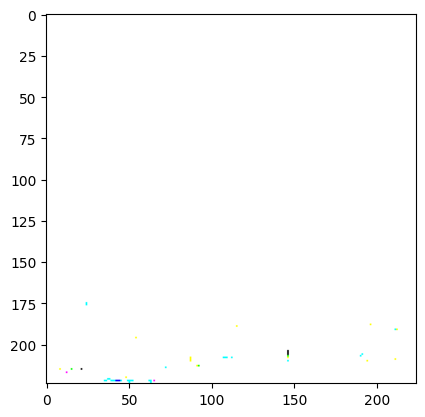

In [19]:
## CLASSIFICATION
transformed_validation_dataset = OpenCVPreprocessor().fit_transform(validation_dataset)
element = next(transformed_validation_dataset.iter_torch_batches(batch_size=1, dtypes=torch.float32))

import matplotlib.pyplot as plt
print(f"CLASS: {ID_CLASS_MAPPING[element['class'].item()]}")
image = np.transpose(element["image"][0], (1, 2, 0))
print(image)
plt.imshow(image)
print(element["image"])
model(element["image"])

In [10]:
param_space = {"train_loop_config": {"lr": tune.loguniform(0.0001, 0.01)}}
metric = "accuracy"

tuner = Tuner(
    trainer,
    param_space=param_space,
    tune_config=TuneConfig(num_samples=3, metric=metric, mode="max"),
)
result_grid = tuner.fit()

best_result = result_grid.get_best_result()
print("Best Result:", best_result)

/var/folders/84/dgy397h5257b3nf_mttpl2xr0000gq/T/ipykernel_29643/2926936654.py:5: UserWarning: Executing `.fit()` may leave less than 20% of CPUs in this cluster for Dataset execution, which can lead to resource contention or hangs. To avoid this, reserve at least 20% of node CPUs for Dataset execution by setting `_max_cpu_fraction_per_node = 0.8` in the Trainer scaling_config. See https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune for more info.
  tuner = Tuner(


(RayTrainWorker pid=29778) 2023-01-08 22:03:22,777	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=10]
(RayTrainWorker pid=29786) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=29781) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=29785) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=29779) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the lo

(RayTrainWorker pid=29778) 0/0:tensor([ 6.,  6.,  8., 15.,  6.,  8., 15.,  6.,  8.,  8.,  8., 15., 15., 15.,
(RayTrainWorker pid=29778)          6.,  6.,  6.,  6.,  8., 15.,  8.,  6.,  6.,  6.,  6., 15.,  8., 15.,
(RayTrainWorker pid=29778)          8., 15., 15., 15.])
(RayTrainWorker pid=29786) 0/0:tensor([8., 8., 5., 0., 0., 5., 5., 0., 8., 8., 8., 8., 5., 0., 0., 5., 0., 8.,
(RayTrainWorker pid=29786)         0., 5., 0., 8., 8., 0., 8., 0., 8., 0., 5., 5., 8., 0.])
(RayTrainWorker pid=29782) 0/0:tensor([12.,  4.,  4.,  4., 15., 15.,  4.,  4., 12.,  4., 12.,  4., 15.,  4.,
(RayTrainWorker pid=29782)         16., 12.,  4., 16., 12., 16., 16., 12., 12.,  4., 15., 15., 16.,  4.,
(RayTrainWorker pid=29782)         15., 16.,  4.,  4.])
(RayTrainWorker pid=29784) 0/0:tensor([ 4.,  5.,  5.,  5.,  4.,  4.,  5.,  5.,  4., 10.,  4.,  5.,  5., 10.,
(RayTrainWorker pid=29784)          4.,  5.,  5.,  5.,  5.,  5., 10., 10.,  5., 10., 10.,  5.,  5.,  5.,
(RayTrainWorker pid=29784)         10.,  5.

Trial name,_time_this_iter_s,_timestamp,_training_iteration,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
TorchTrainer_d90da_00000,460.404,1673212266,1,0.2,2023-01-08_22-11-07,False,,64efe31eb6fa4cc991ea4a230bdecc6e,krk-mp5ek,1,2.5936,127.0.0.1,29759,True,477.248,477.248,477.248,1673212267,0,,1,d90da_00000,0.179687


(RayTrainWorker pid=29778) END OF EPOCH
(RayTrainWorker pid=29781) END OF EPOCH
(RayTrainWorker pid=29786) END OF EPOCH
(RayTrainWorker pid=29782) END OF EPOCH
(RayTrainWorker pid=29785) END OF EPOCH
(RayTrainWorker pid=29779) END OF EPOCH
(RayTrainWorker pid=29784) END OF EPOCH
(RayTrainWorker pid=29787) END OF EPOCH
(RayTrainWorker pid=29780) END OF EPOCH
(RayTrainWorker pid=29783) END OF EPOCH
(RayTrainWorker pid=29778) 1/0:tensor([ 6., 15.,  6.,  8.,  6., 15.,  6.,  6.,  8., 15., 15.,  8., 15., 15.,
(RayTrainWorker pid=29778)         15.,  8.,  6.,  8.,  6.,  8., 15., 15.,  8.,  6.,  8.,  6.,  8.,  8.,
(RayTrainWorker pid=29778)         15., 15.,  8.,  6.])
(RayTrainWorker pid=29781) 1/0:tensor([ 3.,  5.,  3.,  5.,  3.,  5., 12.,  3., 12., 12.,  3.,  5., 12.,  3.,
(RayTrainWorker pid=29781)          5.,  3.,  5.,  3.,  3., 12.,  3.,  5.,  5., 12.,  3.,  5., 12.,  3.,
(RayTrainWorker pid=29781)          5., 12.,  3.,  3.])
(RayTrainWorker pid=29786) 1/0:tensor([0., 5., 8., 0., 0., 5

(RayTrainWorker pid=36384) 2023-01-08 23:18:01,091	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=10]
(RayTrainWorker pid=36385) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=36389) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=36392) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=36393) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the lo

(RayTrainWorker pid=36392) 0/0:tensor([11., 16., 16., 11.,  5., 11., 11., 11., 16., 16., 16.,  5., 11., 11.,
(RayTrainWorker pid=36392)         11.,  5., 11.,  5., 16., 11., 11.,  5., 16., 16., 11., 15., 15., 11.,
(RayTrainWorker pid=36392)         16., 15., 15., 15.])
(RayTrainWorker pid=36386) 0/0:tensor([12., 12., 12., 12., 12., 12., 12.,  5.,  5., 16., 16.,  5., 12., 16.,
(RayTrainWorker pid=36386)          5., 12., 16., 12.,  5.,  5., 12., 16.,  5., 12.,  5., 12., 12.,  5.,
(RayTrainWorker pid=36386)         12.,  5., 12.,  5.])
(RayTrainWorker pid=36384) 0/0:tensor([3., 4., 5., 3., 4., 3., 5., 3., 5., 4., 5., 5., 4., 5., 3., 3., 4., 4.,
(RayTrainWorker pid=36384)         3., 3., 4., 3., 5., 4., 5., 4., 3., 5., 5., 4., 5., 4.])
(RayTrainWorker pid=36389) 0/0:tensor([11.,  3.,  3., 11.,  6.,  6.,  6., 11.,  6., 11.,  6.,  3., 11., 11.,
(RayTrainWorker pid=36389)         11.,  6.,  6.,  3.,  3.,  3., 11., 11.,  3.,  6.,  6.,  6., 11.,  3.,
(RayTrainWorker pid=36389)          3., 11.

2023-01-09 00:06:59,805	WARNING util.py:244 -- The `on_step_end` operation took 2.630 s, which may be a performance bottleneck.


(RayTrainWorker pid=36386) 7/3:tensor([ 4.,  4.,  4.,  5.,  8.,  4.,  4.,  8., 16.,  4.,  8., 11., 16.,  8.,
(RayTrainWorker pid=36386)          4., 11., 11.,  8.,  4., 11., 11., 11., 12.,  6.,  4.,  4.,  4.,  4.,
(RayTrainWorker pid=36386)         12.,  8.,  4.,  4.])
(RayTrainWorker pid=36384) 7/3:tensor([14., 14.,  5., 14.,  4., 14., 14., 14., 14., 14., 14.,  9.,  4., 14.,
(RayTrainWorker pid=36384)         14.,  9.,  9.,  4.,  9., 14.,  5.,  5., 14., 14., 14.,  5.,  9.,  5.,
(RayTrainWorker pid=36384)          5.,  5.,  5.,  5.])
(RayTrainWorker pid=36387) 7/3:tensor([16., 16.,  8.,  2.,  3., 16., 13., 13., 16.,  8., 13., 16.,  3.,  8.,
(RayTrainWorker pid=36387)          8.,  8., 16.,  2.,  8.,  3.,  3.,  3., 16.,  8.,  8.,  2.,  2.,  3.,
(RayTrainWorker pid=36387)         13.,  5.,  5.,  2.])
(RayTrainWorker pid=36385) 7/3:tensor([ 5.,  2.,  2., 16.,  2.,  5., 17.,  5.,  2., 17.,  2.,  2.,  2.,  2.,
(RayTrainWorker pid=36385)          5.,  4.,  2.,  4., 17.,  5.,  4.,  2., 17.,  

(RayTrainWorker pid=42435) 2023-01-09 00:26:42,711	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=10]
(RayTrainWorker pid=42437) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=42443) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=42439) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=42436) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the lo

(RayTrainWorker pid=42436) 0/0:tensor([16.,  4., 16.,  4.,  5.,  4.,  4.,  4., 16., 16.,  5., 16.,  5.,  4.,
(RayTrainWorker pid=42436)          4.,  5.,  5.,  5.,  4.,  4.,  4.,  4.,  4., 16., 16.,  5.,  4., 16.,
(RayTrainWorker pid=42436)         16., 16., 16.,  4.])
(RayTrainWorker pid=42440) 0/0:tensor([11., 11.,  8.,  5.,  5.,  5.,  8.,  8.,  8., 11.,  8., 11.,  5.,  5.,
(RayTrainWorker pid=42440)         11.,  5., 11.,  8.,  8., 11.,  8.,  5., 11.,  8., 11.,  5.,  8., 11.,
(RayTrainWorker pid=42440)          8.,  5.,  5., 11.])
(RayTrainWorker pid=42435) 0/0:tensor([ 5.,  6.,  9.,  5.,  6.,  6.,  5.,  5.,  6., 10., 10.,  6., 10.,  9.,
(RayTrainWorker pid=42435)         10.,  6.,  9.,  6.,  6.,  5.,  5.,  6.,  5.,  5.,  6., 10.,  9.,  6.,
(RayTrainWorker pid=42435)          5.,  9., 10.,  6.])
(RayTrainWorker pid=42439) 0/0:tensor([0., 2., 8., 8., 3., 1., 0., 8., 3., 2., 8., 8., 8., 3., 8., 0., 3., 0.,
(RayTrainWorker pid=42439)         8., 3., 8., 3., 3., 0., 8., 0., 8., 0., 3., 

2023-01-09 01:31:32,593	INFO tune.py:762 -- Total run time: 12506.32 seconds (12506.14 seconds for the tuning loop).


Best Result: Result(metrics={'accuracy': 0.5333333611488342, 'loss': 1.5588997602462769, '_timestamp': 1673220376, '_time_this_iter_s': 410.57702922821045, '_training_iteration': 10, 'should_checkpoint': True, 'done': True, 'trial_id': 'd90da_00001', 'experiment_tag': '1_lr=0.0003'}, error=None, log_dir=PosixPath('/Users/pskupien/ray_results/TorchTrainer_2023-01-08_22-03-06/TorchTrainer_d90da_00001_1_lr=0.0003_2023-01-08_23-17-40'))


In [11]:
## SAVING OF THE MODEL
MODEL_PATH2 = "model2.torch"
model2 = best_result.checkpoint.get_model()
torch.save(model2.state_dict(), MODEL_PATH2)

In [13]:
## LOADING OF THE MODEL
MODEL_PATH2 = "model2.torch"
model2 = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=NUMBER_OF_CLASSES)
model2.load_state_dict(torch.load(MODEL_PATH2))

<All keys matched successfully>

Map_Batches: 100%|██████████| 61/61 [00:04<00:00, 13.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CLASS: International style
tensor([[[ 76., 105., 165.],
         [ 78., 107., 167.],
         [ 77., 106., 166.],
         ...,
         [154., 161., 190.],
         [152., 159., 188.],
         [148., 155., 184.]],

        [[ 77., 106., 166.],
         [ 79., 108., 168.],
         [ 78., 107., 167.],
         ...,
         [156., 163., 192.],
         [153., 160., 189.],
         [148., 155., 184.]],

        [[ 79., 108., 168.],
         [ 81., 110., 170.],
         [ 80., 109., 169.],
         ...,
         [158., 165., 194.],
         [156., 163., 192.],
         [152., 159., 188.]],

        ...,

        [[ 50.,  51.,  55.],
         [ 52.,  53.,  58.],
         [ 52.,  52.,  57.],
         ...,
         [ 22.,  30.,  36.],
         [ 20.,  29.,  36.],
         [ 19.,  29.,  38.]],

        [[ 49.,  50.,  54.],
         [ 48.,  49.,  54.],
         [ 44.,  45.,  49.],
         ...,
         [ 23.,  31.,  37.],
         [ 23.,  32.,  39.],
         [ 19.,  29.,  37.]],

        [

tensor([[ 1.5594,  0.9994,  1.0906, -0.8422,  3.8698,  2.9076,  3.4294,  2.5443,
          1.6500,  2.2986,  3.1735,  2.2236,  1.9101,  1.9954,  1.9118,  1.4934,
          2.6678,  1.1516, -5.2615, -5.3392, -6.1718, -4.8434, -3.5844, -3.3417,
         -5.8084]], grad_fn=<AddmmBackward0>)

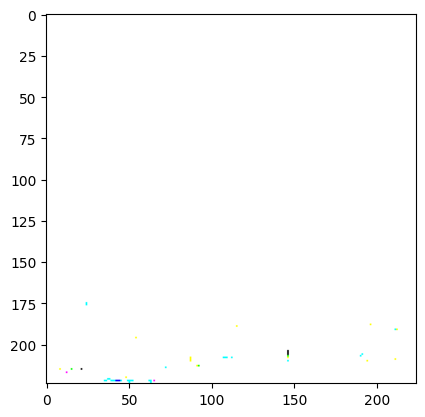

In [14]:
## CLASSIFICATION
transformed_validation_dataset = OpenCVPreprocessor().fit_transform(validation_dataset)
element = next(transformed_validation_dataset.iter_torch_batches(batch_size=1, dtypes=torch.float32))

import matplotlib.pyplot as plt
print(f"CLASS: {ID_CLASS_MAPPING[element['class'].item()]}")
image = np.transpose(element["image"][0], (1, 2, 0))
print(image)
plt.imshow(image)
print(element["image"])
model2(element["image"])